In [3]:
import librosa
import torch
import IPython.display as display
from transformers import Wav2Vec2ForCTC, Wav2Vec2Tokenizer
import numpy as np
from os import listdir
import pandas as pd
import torchaudio


#load pre-trained model and tokenizer
tokenizer = Wav2Vec2Tokenizer.from_pretrained("facebook/wav2vec2-base-960h")
model = Wav2Vec2ForCTC.from_pretrained("facebook/wav2vec2-base-960h")

/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'Wav2Vec2CTCTokenizer'. 
The class this function is called from is 'Wav2Vec2Tokenizer'.
/opt/homebrew/lib/python3.11/site-packages/transformers/models/wav2vec2/tokenization_wav2vec2.py:733: FutureWarning: The class `Wav2Vec2Tokenizer` is deprecated and will be removed in version 5 of Transformers. Please use `Wav2Vec2Processor` or `Wav2Vec2CTCTokenizer` instead.
  warnings.warn(
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weigh

In [2]:
def speechToText(filename):
    audio, sampling_rate = librosa.load(filename,sr=16000)
    input_values = tokenizer(audio, return_tensors = 'pt').input_values
    logits = model(input_values).logits
    predicted_ids = torch.argmax(logits, dim =-1)
    transcriptions = tokenizer.decode(predicted_ids[0])
    return transcriptions

def audioMetadata(filename):
    metadata = torchaudio.info(filename)
    return metadata.sample_rate, metadata.num_frames


In [3]:

train_files = listdir("Medical Speech, Transcription, and Intent/recordings/test")

df_train = pd.DataFrame()
suffix_train = "Medical Speech, Transcription, and Intent/recordings/test/"
transcriptions = []
sample_rates = []
num_of_frames = []
for row in train_files:
    transcriptions.append(speechToText(str(suffix_train + row)))
    sample_rates.append(audioMetadata(str(suffix_train + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_train + row))[1])
df_train["filename"] = train_files
df_train["transcriptions"] = transcriptions
df_train["sample_rate"] = sample_rates
df_train["num_frames"] = num_of_frames

df_train.to_csv("Medical Speech, Transcription, and Intent/transcriptions_train.csv")

In [3]:
test_files = listdir("Medical Speech, Transcription, and Intent/recordings/train")

df_test = pd.DataFrame()
suffix_test = "Medical Speech, Transcription, and Intent/recordings/train/"
transcriptions = []
sample_rates = []
num_of_frames = []
for row in test_files:
    transcriptions.append(speechToText(str(suffix_test + row)))
    sample_rates.append(audioMetadata(str(suffix_test + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_test + row))[1])
df_test["filename"] = test_files
df_test["transcriptions"] = transcriptions
df_test["sample_rate"] = sample_rates
df_test["num_frames"] = num_of_frames

df_test.to_csv("Medical Speech, Transcription, and Intent/transcriptions_test.csv")


In [4]:
validation_files = listdir("Medical Speech, Transcription, and Intent/recordings/validate")

df_validation = pd.DataFrame()
suffix_validation = "Medical Speech, Transcription, and Intent/recordings/validate/"
transcriptions = []
sample_rates = []
num_of_frames = []
for row in validation_files:
    transcriptions.append(speechToText(str(suffix_validation + row)))
    sample_rates.append(audioMetadata(str(suffix_validation + row))[0])
    num_of_frames.append(audioMetadata(str(suffix_validation + row))[1])
df_validation["filename"] = validation_files
df_validation["transcriptions"] = transcriptions
df_validation["sample_rate"] = sample_rates
df_validation["num_frames"] = num_of_frames

df_validation.to_csv("Medical Speech, Transcription, and Intent/transcriptions_validate.csv")

In [8]:
from transformers import pipeline

fix_spelling = pipeline("text2text-generation",model="oliverguhr/spelling-correction-english-base")

print(fix_spelling('MY HUSBAND HAS A SPOT ON HIS LIP THAT HE THOUGHT WAS COLDSORE BUT NOW IT HAS BROKEN OPEN AND LEAKS FLUID ALL DAY',max_length=2048))


[{'generated_text': 'MY HUSBAND HAS A SPOT ON HIS LIP THAT HE THOUGHT WAS COLDSORE BUT NOW IT HAS BROKEN, FREE AND LEAKS FLUID ALL DAY.'}]


In [4]:
df_gen_1 = pd.read_csv("Medical Speech, Transcription, and Intent/transcriptions_test.csv")
df_gen_2 = pd.read_csv("Medical Speech, Transcription, and Intent/transcriptions_train.csv")
df_gen_3 = pd.read_csv("Medical Speech, Transcription, and Intent/transcriptions_validate.csv")

df_gen = pd.concat([df_gen_1,df_gen_2,df_gen_3])

In [6]:
df_org = pd.read_csv("Medical Speech, Transcription, and Intent/labels.csv")

In [7]:
df_comb = pd.merge(df_gen,df_org,left_on="filename",right_on="file_name",how="inner")

In [19]:
df_test = pd.merge(df_gen_1,df_org,left_on="filename",right_on="file_name",how="inner")[["filename","transcriptions","sample_rate","num_frames","prompt"]]
df_train = pd.merge(df_gen_2,df_org,left_on="filename",right_on="file_name",how="inner")[["filename","transcriptions","sample_rate","num_frames","prompt"]]
df_validate = pd.merge(df_gen_3,df_org,left_on="filename",right_on="file_name",how="inner")[["filename","transcriptions","sample_rate","num_frames","prompt"]]

In [62]:
df_test = pd.merge(df_gen_1,df_org,left_on="filename",right_on="file_name",how="inner")[["transcriptions","prompt"]]
df_train = pd.merge(df_gen_2,df_org,left_on="filename",right_on="file_name",how="inner")[["transcriptions","prompt"]]
df_validate = pd.merge(df_gen_3,df_org,left_on="filename",right_on="file_name",how="inner")[["transcriptions","prompt"]]

In [8]:
df_final = df_comb[["filename","transcriptions","sample_rate","num_frames","prompt"]]

In [11]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Load dataset
data = df_final

# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['transcriptions'], data['prompt'], test_size=0.2, random_state=42
)

# Load pre-trained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Transform train and test texts
train_embeddings = model.encode(train_texts.tolist(), convert_to_tensor=True).cpu().numpy()
test_embeddings = model.encode(test_texts.tolist(), convert_to_tensor=True).cpu().numpy()

# Train Logistic Regression classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_embeddings, train_labels)

# Predict on test set
predictions = classifier.predict(test_embeddings)

# Evaluate model
print(classification_report(test_labels, predictions))


                    precision    recall  f1-score   support

              Acne       0.63      0.69      0.66        61
         Back pain       0.75      0.77      0.76        47
     Blurry vision       0.75      0.85      0.80        46
   Body feels weak       0.81      0.75      0.78        52
             Cough       0.51      0.65      0.57        54
          Ear ache       0.75      0.71      0.73        51
    Emotional pain       0.69      0.78      0.73        40
      Feeling cold       0.75      0.81      0.78        47
     Feeling dizzy       0.74      0.81      0.78        64
         Foot ache       0.64      0.72      0.68        40
  Hair falling out       0.85      0.80      0.82        50
    Hard to breath       0.81      0.71      0.76        42
         Head ache       0.67      0.61      0.64        51
       Heart hurts       0.77      0.73      0.75        51
    Infected wound       0.70      0.77      0.73        60
Injury from sports       0.68      0.59

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Define a simple feedforward neural network classifier
class Classifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Load dataset
data = df_final

# Encode class labels
label_encoder = LabelEncoder()
data['encoded_category'] = label_encoder.fit_transform(data['prompt'])

# Check column names
print(data.columns)

# Split dataset into train and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(
    data['transcriptions'], data['encoded_category'], test_size=0.2, random_state=42
)

# Load pre-trained Sentence Transformer model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Transform train and test texts
train_embeddings = model.encode(train_texts.tolist(), convert_to_tensor=True)
test_embeddings = model.encode(test_texts.tolist(), convert_to_tensor=True)

# Move model and data to CPU
classifier = Classifier(train_embeddings.size(1), 512, len(label_encoder.classes_)).cpu()
train_embeddings = train_embeddings.cpu()
test_embeddings = test_embeddings.cpu()
train_labels = train_labels.astype('int64').values
test_labels = test_labels.astype('int64').values

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Train classifier
num_epochs = 10
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = classifier(train_embeddings)
    loss = criterion(outputs, torch.tensor(train_labels))
    loss.backward()
    optimizer.step()

# Predict on test set
with torch.no_grad():
    outputs = classifier(test_embeddings)
    _, predicted = torch.max(outputs, 1)

# Convert tensors to numpy arrays
predicted = predicted.numpy()

# Decode predicted labels
predicted_labels = label_encoder.inverse_transform(predicted)

# Evaluate model
print(classification_report(test_labels, predicted))


/var/folders/ff/p_bz9_rx7nj5zwyv95wmykx00000gn/T/ipykernel_84621/3192024590.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['encoded_category'] = label_encoder.fit_transform(data['prompt'])


Index(['filename', 'transcriptions', 'sample_rate', 'num_frames', 'prompt',
       'encoded_category'],
      dtype='object')
              precision    recall  f1-score   support

           0       0.22      0.87      0.36        61
           1       0.79      0.57      0.67        47
           2       0.79      0.80      0.80        46
           3       0.86      0.46      0.60        52
           4       0.37      0.59      0.46        54
           5       0.79      0.65      0.71        51
           6       0.92      0.57      0.71        40
           7       0.49      0.72      0.58        47
           8       0.70      0.78      0.74        64
           9       1.00      0.30      0.46        40
          10       0.91      0.60      0.72        50
          11       0.84      0.38      0.52        42
          12       0.77      0.45      0.57        51
          13       0.72      0.67      0.69        51
          14       0.45      0.63      0.52        60
         

/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.2917 - loss: 2.5908 - val_accuracy: 0.5526 - val_loss: 1.6274
Epoch 2/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6042 - loss: 1.4786 - val_accuracy: 0.6321 - val_loss: 1.3742
Epoch 3/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6705 - loss: 1.2199 - val_accuracy: 0.6486 - val_loss: 1.3000
Epoch 4/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7215 - loss: 1.0366 - val_accuracy: 0.6532 - val_loss: 1.2579
Epoch 5/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7456 - loss: 0.9526 - val_accuracy: 0.6847 - val_loss: 1.1929
Epoch 6/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.8500 - val_accuracy: 0.6712 - val_loss: 1.2053
Epoch 7/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7901 - loss: 0.7639 - val_accuracy: 0.6922 - val_loss: 1.1650
Epoch 8/20
167/167 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8127 - loss: 0.6810 - val_accuracy: 0.

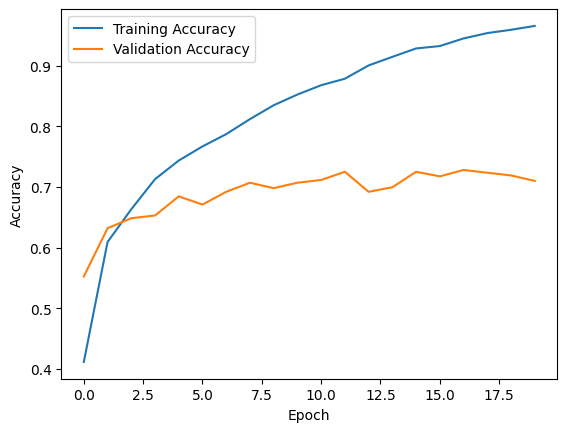

In [50]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load your data
# Assuming you have loaded your data into df_final

# Split data into features (transcriptions) and labels (prompt)
X = df_final['transcriptions'].values
y = pd.get_dummies(df_final['prompt']).values  # Assuming one-hot encoding for class labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained Sentence Transformers model
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode text inputs using Sentence Transformers model
X_train_encoded = sentence_transformer_model.encode(X_train, convert_to_tensor=True)
X_train_encoded = X_train_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_val_encoded = sentence_transformer_model.encode(X_val, convert_to_tensor=True)
X_val_encoded = X_val_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_test_encoded = sentence_transformer_model.encode(X_test, convert_to_tensor=True)
X_test_encoded = X_test_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

# Define input shape
input_text = Input(shape=(X_train_encoded.shape[1],), dtype=tf.float32)

# Dense layer for classification
dense = Dense(128, activation='relu')(input_text)
output = Dense(y.shape[1], activation='softmax')(dense)  # Number of classes based on one-hot encoding

# Define model
model = Model(inputs=input_text, outputs=output)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(X_train_encoded, y_train, batch_size=32, epochs=20, validation_data=(X_val_encoded, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.3925 - loss: 2.2498 - val_accuracy: 0.6306 - val_loss: 1.3491
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6731 - loss: 1.2051 - val_accuracy: 0.6832 - val_loss: 1.2387
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7415 - loss: 0.9471 - val_accuracy: 0.6817 - val_loss: 1.1945
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8024 - loss: 0.7159 - val_accuracy: 0.7012 - val_loss: 1.1485
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8391 - loss: 0.5831 - val_accuracy: 0.6922 - val_loss: 1.1636
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8752 - loss: 0.4493 - val_accuracy: 0.6997 - val_loss: 1.2124
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9150 - loss: 0.3550 - val_accuracy: 0.7252 - val_loss: 1.1352
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9340 - loss: 0.2668 - val_accuracy: 0.

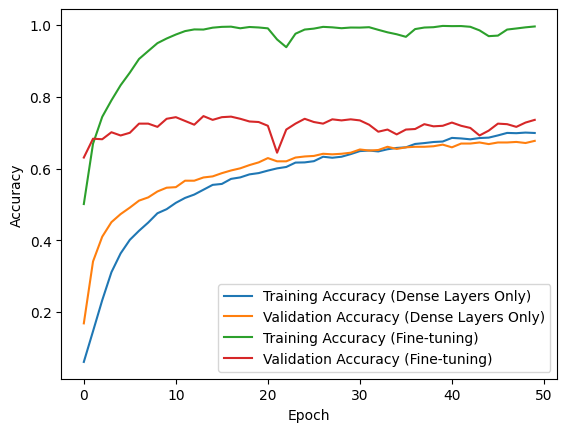

In [96]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load your data
# Assuming you have loaded your data into df_final

# Split data into features (transcriptions) and labels (prompt)
X = df_final['transcriptions'].values
y = pd.get_dummies(df_final['prompt']).values  # Assuming one-hot encoding for class labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained Sentence Transformers model
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode text inputs using Sentence Transformers model
X_train_encoded = sentence_transformer_model.encode(X_train, convert_to_tensor=True)
X_train_encoded = X_train_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_val_encoded = sentence_transformer_model.encode(X_val, convert_to_tensor=True)
X_val_encoded = X_val_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_test_encoded = sentence_transformer_model.encode(X_test, convert_to_tensor=True)
X_test_encoded = X_test_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

# Define input shape
input_text = Input(shape=(X_train_encoded.shape[1],), dtype=tf.float32)

# Dense layer for classification
dense = Dense(1024, activation='relu')(input_text)
output = Dense(y.shape[1], activation='softmax')(dense)  # Number of classes based on one-hot encoding

# Define model
model = Model(inputs=input_text, outputs=output)

# # Compile model
# model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# # Train only the added Dense layers
# history = model.fit(X_train_encoded, y_train, batch_size=32, epochs=5, validation_data=(X_val_encoded, y_val))

# Unlock the Sentence Transformers model for further fine-tuning
for layer in sentence_transformer_model.parameters():
    layer.requires_grad = True
# Compile the model again to apply changes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the entire model
history_finetune = model.fit(X_train_encoded, y_train, batch_size=32, epochs=50, validation_data=(X_val_encoded, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy (Dense Layers Only)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Dense Layers Only)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.0493 - loss: 3.3215 - val_accuracy: 0.1682 - val_loss: 3.0106
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.1290 - loss: 3.0420 - val_accuracy: 0.3408 - val_loss: 2.7856
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2157 - loss: 2.8450 - val_accuracy: 0.4099 - val_loss: 2.6013
Epoch 4/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.2970 - loss: 2.6722 - val_accuracy: 0.4505 - val_loss: 2.4434
Epoch 5/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3391 - loss: 2.5321 - val_accuracy: 0.4730 - val_loss: 2.3103
Epoch 6/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.3898 - loss: 2.3818 - val_accuracy: 0.4910 - val_loss: 2.1973
Epoch 7/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4303 - loss: 2.2486 - val_accuracy: 0.5105 - val_loss: 2.1026
Epoch 8/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.4548 - loss: 2.1620 - val_accuracy:

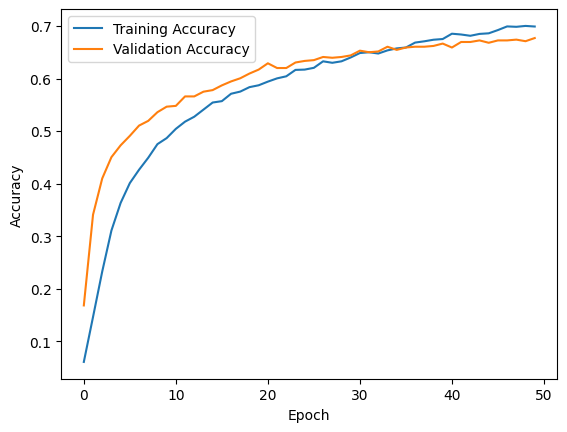

In [95]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Load your data
# Assuming you have loaded your data into df_final

# Split data into features (transcriptions) and labels (prompt)
X = df_final['transcriptions'].values
y = pd.get_dummies(df_final['prompt']).values  # Assuming one-hot encoding for class labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained Sentence Transformers model
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode text inputs using Sentence Transformers model
X_train_encoded = sentence_transformer_model.encode(X_train, convert_to_tensor=True)
X_train_encoded = X_train_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_val_encoded = sentence_transformer_model.encode(X_val, convert_to_tensor=True)
X_val_encoded = X_val_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_test_encoded = sentence_transformer_model.encode(X_test, convert_to_tensor=True)
X_test_encoded = X_test_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array


# Define input shape
input_text = Input(shape=(X_train_encoded.shape[1],), dtype=tf.float32)

# Dense layers for classification with dropout
dense = Dense(2048, activation='relu')(input_text)
dropout = Dropout(0.5)(dense)
output = Dense(y.shape[1], activation='softmax')(dropout)  # Number of classes based on one-hot encoding

# Define model
model = Model(inputs=input_text, outputs=output)

# Compile model with Adam optimizer and a lower learning rate
optimizer = Adam(learning_rate=1e-5)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model with a lower learning rate and more epochs
history = model.fit(X_train_encoded, y_train, batch_size=32, epochs=50, validation_data=(X_val_encoded, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
# Convert X_train and X_test to lists of strings
X_train_list = X_train.tolist()
X_train_list = list(map(str, X_train_list))
X_test_list = X_test.tolist()
X_test_list = list(map(str, X_test_list))


In [83]:
X = df_final['transcriptions'].values
y = df_final['prompt'].values  # Assuming no need for one-hot encoding

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.tolist()

['EVERYTHING LOOKS BEING IN IS MOKY ARIA',
 "MY BACK HURTS ME AND I CAN'T BEND IT OR WALK",
 'I HAVE A SHARP PAN IN MY NECK',
 'I HAVE A FUDACE AFTER RUNNING FIVE HUNDRED DEN UP RUNNING SHOES',
 'THE LAST LOOKER AND WAL LA LIT MADLY THE ONE THEY SAW A WINE',
 'I AM STRUGGLING TO BEAR WIT ON MY KNEE WHEN I STAND STRAIGHT I WEL AND HEAR A LOUD POPPING NOISE',
 'MY AGONY EACHES AND ROGES',
 'I FEEL DEPRESSED WHEN I SEE MY HAIR FALLEN OUT',
 'I SLICED MYSELF DEEPLY WITH A KNIFE WHILE I WAS COOKING',
 "I CAN'T WALK WELL I HAVE AN ACHE IN MY FOOT",
 'I HAVE MUSCLE PAIN AT MY LEFT LEG',
 'I GOULD BY HANG ACUPLESE AV ALL I LOVE OH I LITE TING I II ITE E CAT AN CLOTHES UP',
 "I HAVE JUMPIN WE AND I'M WORKING UT ON MY NE",
 'MY HAIR ALWAYS CALLED OUT AND I HAVE LOST A LET A HAIR ME',
 'WHEN I BRUSHED MY HAIR I NOTICED BIG CLUMPS OF HAIR COMING OUT IN THE BRUSH',
 'I FEEL PAIN IN MY SHU DUST WHEN I WRITE UN ZE KEBOG',
 'MY UPPER BACK HAS BEEN SORE FOR A WEEK',
 'I HAVE A DUL ATCHE IN MY STOMARK I

Epoch 1/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.3859 - loss: 2.2293 - val_accuracy: 0.6021 - val_loss: 1.3784
Epoch 2/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6617 - loss: 1.2064 - val_accuracy: 0.6486 - val_loss: 1.2580
Epoch 3/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7356 - loss: 0.9297 - val_accuracy: 0.6862 - val_loss: 1.1748
Epoch 4/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7851 - loss: 0.7415 - val_accuracy: 0.7087 - val_loss: 1.1036
Epoch 5/5
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8484 - loss: 0.5709 - val_accuracy: 0.6862 - val_loss: 1.1410
Epoch 1/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8508 - loss: 0.5162 - val_accuracy: 0.7012 - val_loss: 1.1609
Epoch 2/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9096 - loss: 0.3629 - val_accuracy: 0.7087 - val_loss: 1.2154
Epoch 3/50
167/167 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9311 - loss: 0.2756 - val_accuracy: 0.7132 

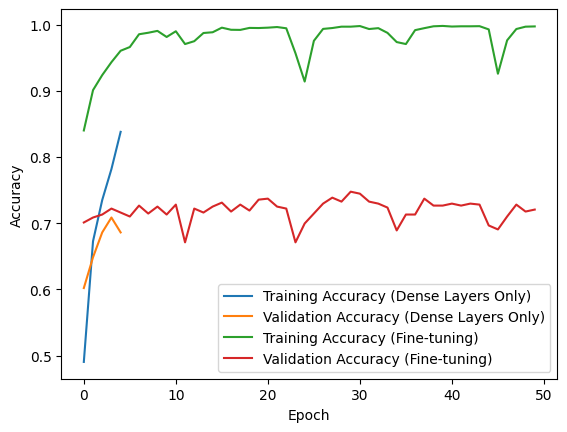

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


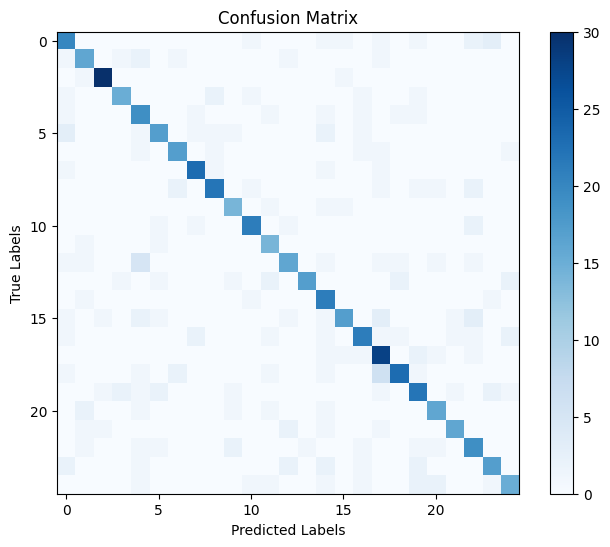

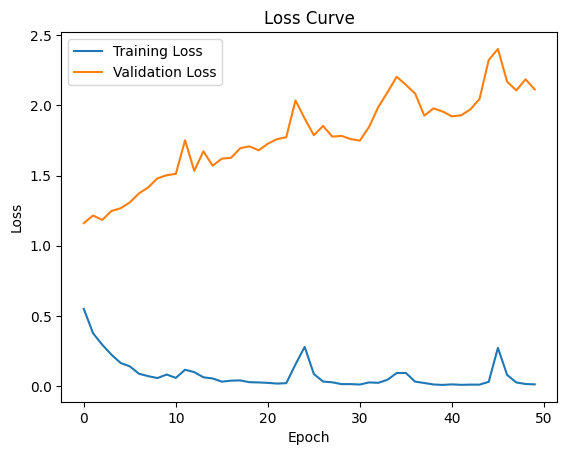

In [15]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt

# Load your data
# Assuming you have loaded your data into df_final

# Split data into features (transcriptions) and labels (prompt)
X = df_final['transcriptions'].values
y = pd.get_dummies(df_final['prompt']).values  # Assuming one-hot encoding for class labels

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Load pre-trained Sentence Transformers model
sentence_transformer_model = SentenceTransformer('bert-base-nli-mean-tokens')

# Encode text inputs using Sentence Transformers model
X_train_encoded = sentence_transformer_model.encode(X_train, convert_to_tensor=True)
X_train_encoded = X_train_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_val_encoded = sentence_transformer_model.encode(X_val, convert_to_tensor=True)
X_val_encoded = X_val_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

X_test_encoded = sentence_transformer_model.encode(X_test, convert_to_tensor=True)
X_test_encoded = X_test_encoded.cpu().numpy()  # Copy tensor to CPU and then convert to numpy array

# Define input shape
input_text = Input(shape=(X_train_encoded.shape[1],), dtype=tf.float32)

# Dense layer for classification
dense = Dense(1024, activation='relu')(input_text)
output = Dense(y.shape[1], activation='softmax')(dense)  # Number of classes based on one-hot encoding

# Define model
model = Model(inputs=input_text, outputs=output)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train only the added Dense layers
history = model.fit(X_train_encoded, y_train, batch_size=32, epochs=5, validation_data=(X_val_encoded, y_val))

# Unlock the Sentence Transformers model for further fine-tuning
for layer in sentence_transformer_model.parameters():
    layer.requires_grad = True
# Compile the model again to apply changes
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the entire model
history_finetune = model.fit(X_train_encoded, y_train, batch_size=32, epochs=50, validation_data=(X_val_encoded, y_val))

# Evaluate model
test_loss, test_acc = model.evaluate(X_test_encoded, y_test)
print(f'Test accuracy: {test_acc}')

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy (Dense Layers Only)')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy (Dense Layers Only)')
plt.plot(history_finetune.history['accuracy'], label='Training Accuracy (Fine-tuning)')
plt.plot(history_finetune.history['val_accuracy'], label='Validation Accuracy (Fine-tuning)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = np.argmax(model.predict(X_test_encoded), axis=1)
y_true = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap=plt.cm.Blues)
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Plot Loss Curve
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

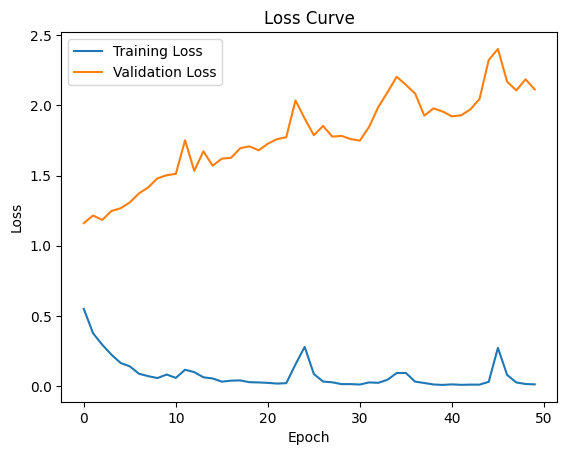

In [16]:
# Plot Loss Curve
plt.plot(history_finetune.history['loss'], label='Training Loss')
plt.plot(history_finetune.history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


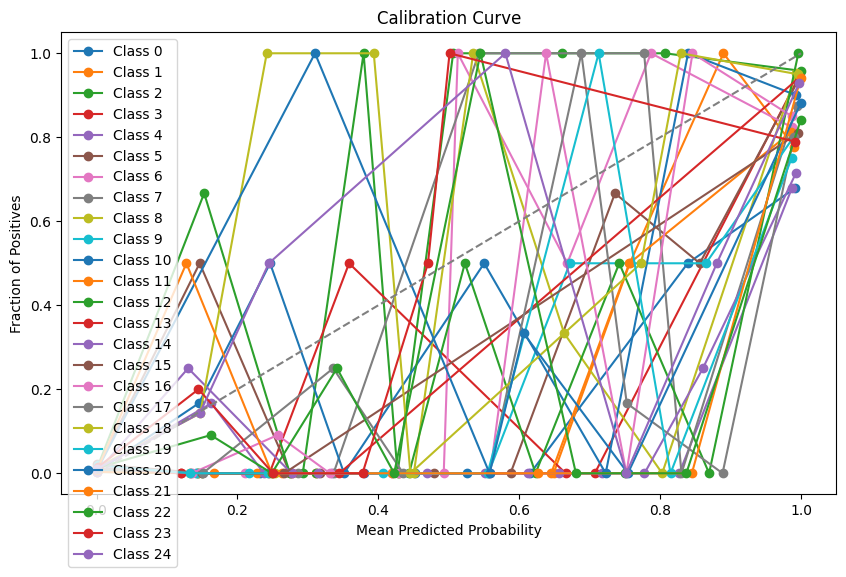

In [18]:
from sklearn.calibration import calibration_curve

# Predict probabilities for the test set
y_prob = model.predict(X_test_encoded)

# Prepare data for calibration curve
calibration_data = {}
for i in range(y_test.shape[1]):  # Iterate over each class
    prob_true, prob_pred = calibration_curve(y_test[:, i], y_prob[:, i], n_bins=10)
    calibration_data[i] = {'prob_true': prob_true, 'prob_pred': prob_pred}

# Plot calibration curves for each class
plt.figure(figsize=(10, 6))
for i in range(y_test.shape[1]):
    plt.plot(calibration_data[i]['prob_pred'], calibration_data[i]['prob_true'], marker='o', linestyle='-', label=f'Class {i}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Perfectly calibrated line
plt.title('Calibration Curve')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.legend()
plt.show()
